In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [2]:
# Read dataset file
df = pd.read_csv('Honda.csv', delimiter=";")
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [3]:
print(df.dtypes)

Date      object
Price     object
Open      object
High      object
Low       object
Volume    object
Change    object
dtype: object


In [4]:
df['Price'] = df['Price'].str.replace(',', '.').astype(float)
df['Open'] = df['Open'].str.replace(',', '.').astype(float)
df['High'] = df['High'].str.replace(',', '.').astype(float)
df['Low'] = df['Low'].str.replace(',', '.').astype(float)
df['Volume'] = df['Volume'].str.replace(',', '.').astype(float)
df['Change'] = df['Change'].str.replace(',', '.').astype(float)

print(df)
df.describe()

            Date   Price    Open    High     Low      Volume  Change
0     04/01/2018  1328.7  1308.3  1328.7  1302.0  14890000.0  0.0322
1     05/01/2018  1340.3  1333.3  1351.3  1330.0  14300000.0  0.0087
2     09/01/2018  1336.7  1347.3  1352.3  1332.3  10340000.0 -0.0027
3     10/01/2018  1367.3  1345.0  1383.7  1342.7  14080000.0  0.0229
4     11/01/2018  1342.0  1345.0  1351.7  1332.7  12090000.0 -0.0185
...          ...     ...     ...     ...     ...         ...     ...
1447  08/12/2023  1458.0  1488.0  1490.0  1450.5  28600000.0 -0.0257
1448  11/12/2023  1494.5  1496.0  1501.0  1486.5  14850000.0  0.0250
1449  12/12/2023  1477.5  1501.0  1502.0  1477.5  11320000.0 -0.0114
1450  13/12/2023  1469.0  1476.5  1477.0  1456.0  14080000.0 -0.0058
1451  14/12/2023  1395.5  1434.0  1439.5  1389.0  27040000.0 -0.0500

[1452 rows x 7 columns]


,Price,Open,High,Low,Volume,Change
count,1452.000000,1452.000000,1452.000000,1452.000000,1.452000e+03,1452.000000
mean,1105.688912,1106.123485,1115.705579,1095.946556,1.393168e+07,0.000222
std,183.522697,184.289369,184.962911,182.567989,5.240151e+06,0.018327
min,711.800000,717.200000,746.700000,706.700000,3.360000e+06,-0.071000
25%,995.375000,995.725000,1005.600000,986.525000,1.040000e+07,-0.010100
50%,1087.000000,1088.300000,1097.150000,1078.150000,1.284000e+07,0.000000
75%,1172.700000,1174.400000,1181.325000,1163.850000,1.624750e+07,0.010225
max,1802.300000,1802.300000,1821.000000,1780.000000,4.645000e+07,0.106200


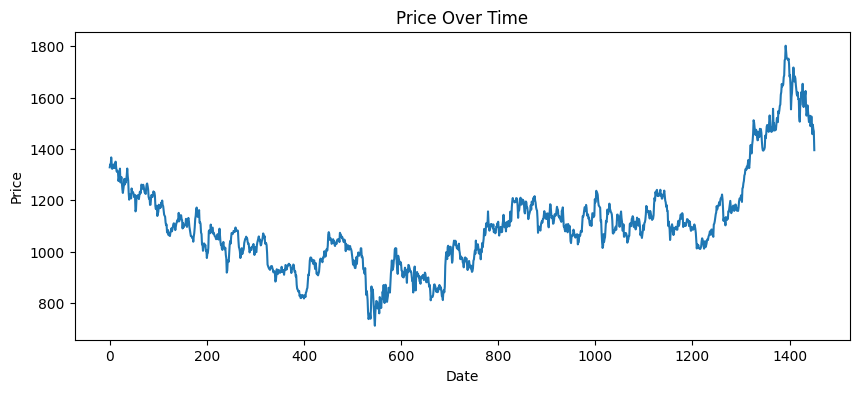

In [5]:
# Assuming you have a DataFrame 'df' with a 'Price' column
plt.figure(figsize=(10, 4))
plt.plot(df['Price'])
plt.title('Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [6]:
# Split the data into training & testing sets by 7:3
train_size = int(0.6 * len(df['Price']))
test_size = len(df['Price']) - train_size

train_data = df[:train_size]
test_data = df[train_size:train_size + test_size]

In [7]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7580.365, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7582.248, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7584.243, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7584.242, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7580.310, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7582.139, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.970 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [8]:
# make predictions on the testing set
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [9]:
# 6. Create index next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))


In [10]:
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - y_test))
print("Testing MAE:", test_mae)

def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * (error ** 2)
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    loss = np.where(is_small_error, squared_loss, linear_loss)
    return np.mean(loss)

# Calculate Huber Loss for the testing set
test_huber_loss = huber_loss(y_test, y_pred, delta=1.0)
print("Testing Huber Loss:", test_huber_loss)

Testing RMSE: 192.7287860102137
Testing MAPE: 10.412530176636837
Testing MAE: 138.90189328743543
Testing Huber Loss: 138.40189328743543


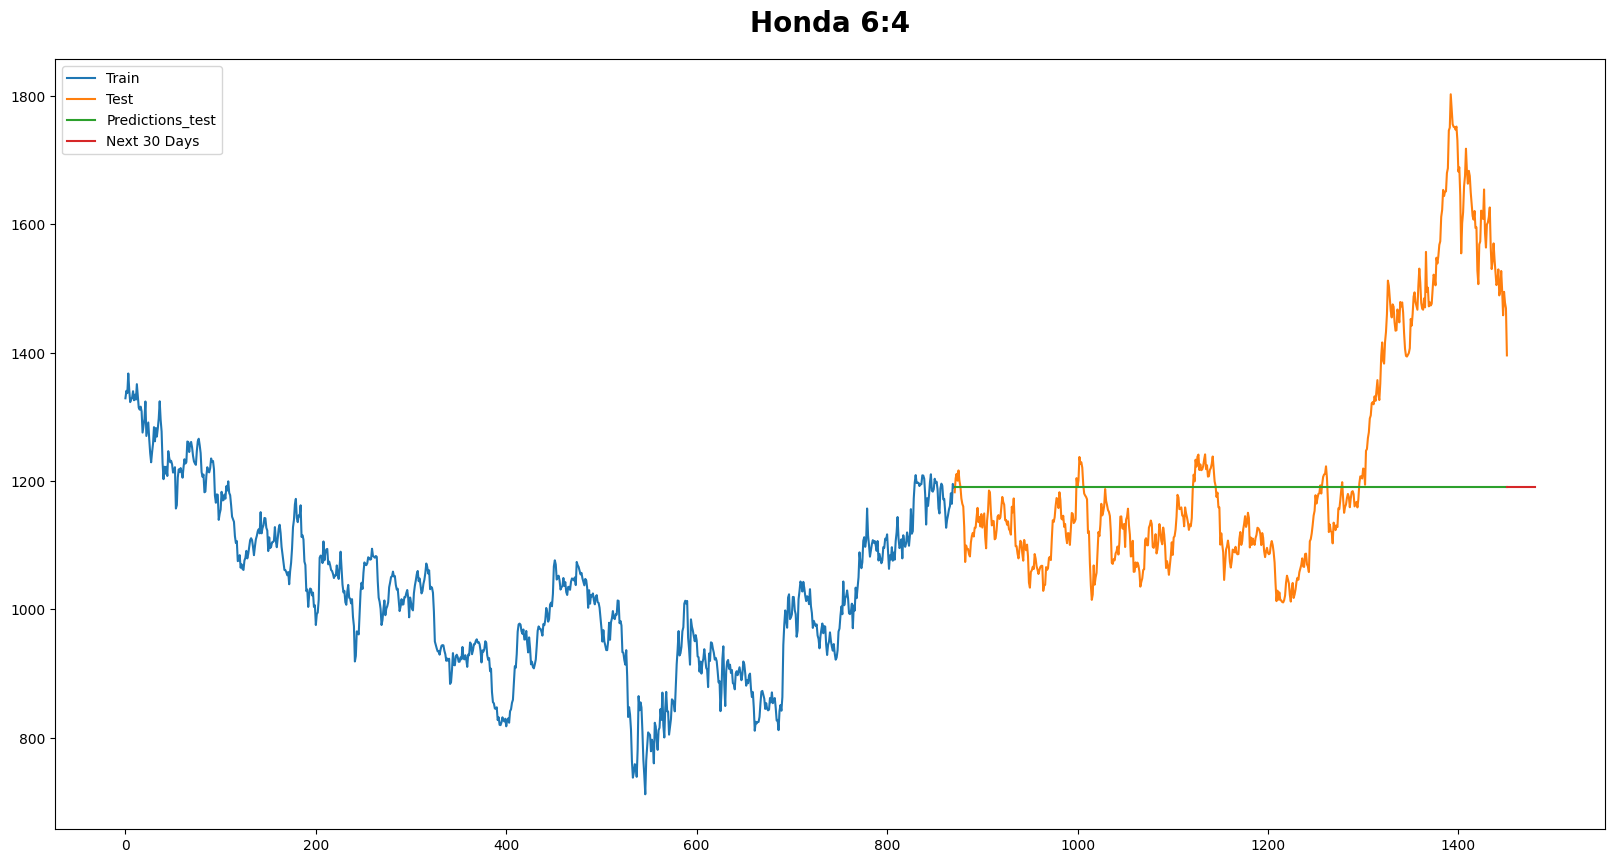

In [11]:
# Plotting the actual values and predicted values
plt.figure(figsize=(20, 10))

# Plot train data
plt.plot(train_data.index, train_data['Price'], label='Train')

# Plot test data
plt.plot(test_data.index, test_data['Price'], label='Test')

# Plot predicted values for the test set
plt.plot(test_data.index, y_pred, label='Predictions_test')

# Plot predicted values for the next 30 days
plt.plot(last_data, y_next_30_days, label='Next 30 Days')

plt.title('Honda 6:4', fontweight='bold', fontsize=20, pad=20)
plt.legend()
plt.show()
